# PyDMD

## Tutorial 19: Hankel Alternative View of Koopman (HAVOK)

In this tutorial, we demonstrate a basic use case of the Hankel Alternative View of Koopman (HAVOK) approach [1] for modeling chaotic systems with partial measurements. In this tutorial, we specifically apply HAVOK to the chaotic Lorenz system, and in the process, we showcase all basic features and parameters of the `HAVOK` module.

We begin with some basic imports, including `numpy` for computations, `matplotlib` for plotting, `solve_ivp` for data simulation, and of course, the `HAVOK` module of the PyDMD package for HAVOK applications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pydmd import HAVOK

### The Chaotic Lorenz System

Throughout this tutorial, we examine the Lorenz system

$$
\begin{cases}
\dot{x} = \sigma (y-x) \\
\dot{y} = x(\rho-z)-y \\ 
\dot{z} = xy - \beta z
\end{cases}
$$

for the parameters $\sigma, \rho, \beta = 10, 28, 8/3$ and the initial condition $(x_0, y_0, z_0) = (-8,8,27)$. Below we provide code that uses `scipy.integrate.solve_ivp` to propagate this system forward in time. We additionally provide code that uses $x$ data from the Lorenz system in order to detect lobe switching events.

In [2]:
def generate_lorenz_data(t_eval):
    """
    Given a time vector t_eval = t1, t2, ..., evaluates and returns
    the snapshots of the Lorenz system as columns of the matrix X.
    """

    def lorenz_system(t, state):
        sigma, rho, beta = 10, 28, 8 / 3  # chaotic parameters
        x, y, z = state
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return [x_dot, y_dot, z_dot]

    # Set integrator keywords to replicate the odeint defaults
    integrator_keywords = {}
    integrator_keywords["rtol"] = 1e-12
    integrator_keywords["atol"] = 1e-12
    integrator_keywords["method"] = "LSODA"

    sol = solve_ivp(
        lorenz_system,
        [t_eval[0], t_eval[-1]],
        [-8, 8, 27],
        t_eval=t_eval,
        **integrator_keywords,
    )

    return sol.y


def get_ind_switch_lorenz(x):
    """
    Get indices of true lobe switching of the Lorenz system given x data.
    """
    ind_switch = np.sign(x[:-1]) - np.sign(x[1:]) != 0
    ind_switch = np.append(ind_switch, False)
    ind_switch = np.where(ind_switch)[0]

    return ind_switch

We start by simulating Lorenz data for the fine time-step $\Delta t = 0.001$ over $m = 50000$ time points. We then plot the full-state Lorenz system, along with the $x$ coordinate from the Lorenz system. Throughout this tutorial, **we assume that we only have access to $x$ coordinate data. This will be our partial measurement data.**

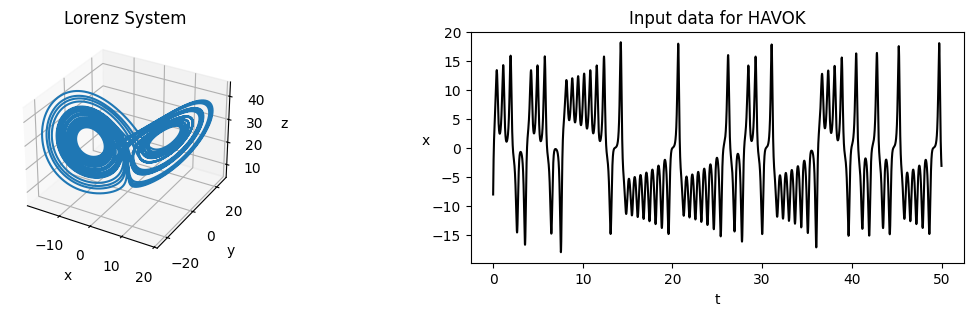

In [3]:
# Generate Lorenz system data.
dt = 0.001  # time step
m = 50000  # number of data samples
t = np.arange(m) * dt
X = generate_lorenz_data(t)
x = X[0]

# Plot the 3D attractor.
fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(121, projection="3d")
ax.plot(X[0], X[1], X[2])
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# Plot the x time-series.
ax = fig.add_subplot(122)
ax.set_title("Input data for HAVOK")
ax.plot(t, x, c="k")
ax.set_xlabel("t")
ax.set_ylabel("x", rotation=0)
plt.show()

### Basic HAVOK application

In order to apply HAVOK to your data, simply initialize a `HAVOK` model with your desired parameters and invoke the model's `fit` method. Note that input snapshots and time information (either all times of data collection or the time-step $\Delta t$) are both necessary for model fitting.

In [4]:
havok = HAVOK(svd_rank=16, delays=100)
havok.fit(x, t)

### Summary plotting

Once fitted, the `HAVOK`-specific `plot_summary` function may be used to visualize all major HAVOK results. These results include:
- The time-series used to fit the HAVOK model.
- The HAVOK regression matrix, which contains the operators $\mathbf{A}$ and $\mathbf{B}$, as well as the "bad fit".
- The first time-delay coordinate $v_1$.
- The forcing input term $v_r$ and the times the forcing is considered "active".
- The attractor recovered via time-delay, plotted with the "active" times.
- The attractor that is reconstructed using the fitted HAVOK model.

Notice that by applying HAVOK, we are able to (1) recover an attractor that very closely ressembles the true full-state system, (2) obtain a forcing signal that "activates" prior to switching events, and (3) obtain a linear regression model that very accurately models our time-delay coordinates, **all from just using $x$ coordinate data alone!**

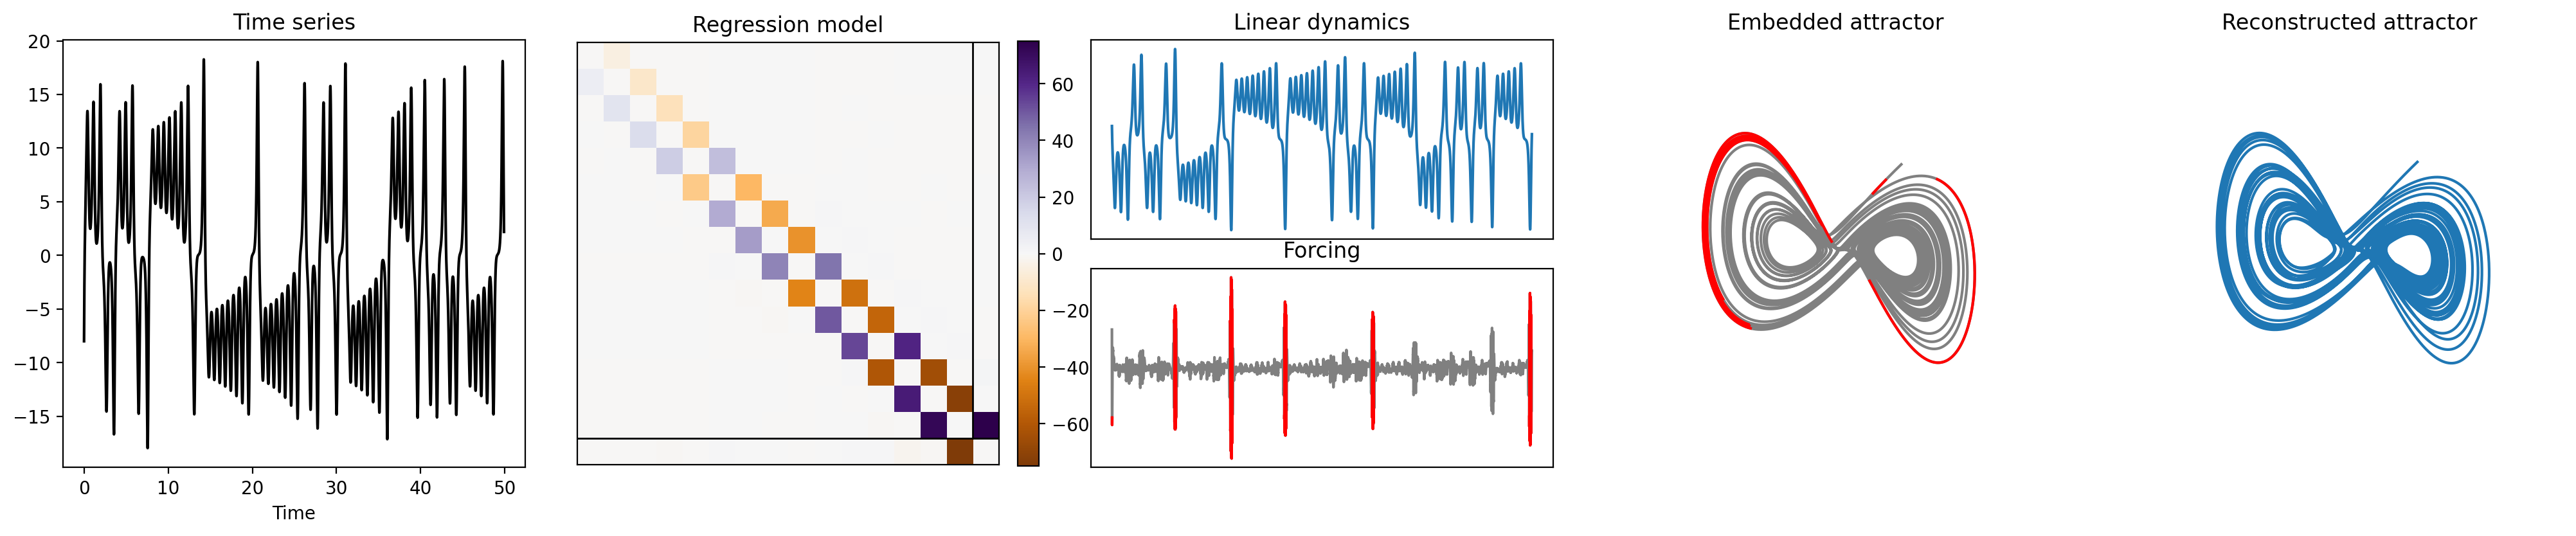

In [5]:
havok.plot_summary()

### Summary plotting customization

The `plot_summary` function is also quite customizable. Here are just a handful of ways in which one might customize their plots. See method documentation for more details. Method header is provided for convenience.

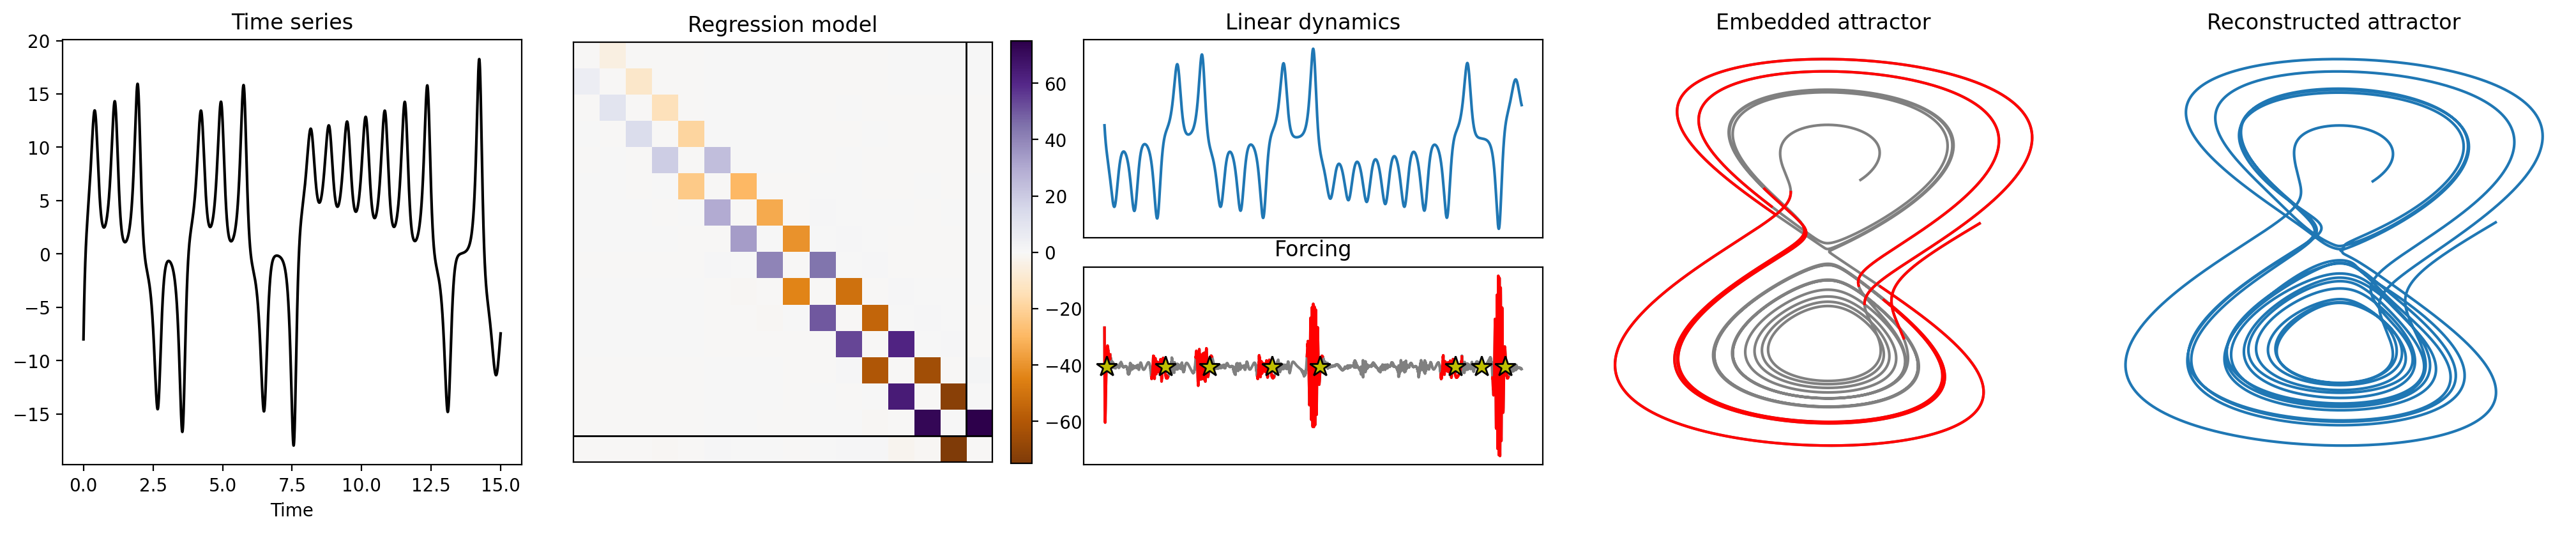

In [6]:
"""
def plot_summary(
    self,
    num_plot=None,
    index_linear=(0, 1, 2),
    index_forcing=0,
    forcing_threshold=None,
    min_jump_dist=None,
    true_switch_indices=None,
    figsize=(20, 4),
    dpi=200,
    filename=None,
):
"""
havok.plot_summary(
    # Number of data points to plot.
    num_plot=15000,
    # Indices of the embeddings to plot (and their order).
    index_linear=(1, 0),
    # Threshold at which the forcing is considered large enough to be active.
    forcing_threshold=0.005,
    # Indices of true switching events (plotted on the forcing plot as as stars).
    true_switch_indices=get_ind_switch_lorenz(x),
)

### Data reconstruction

Once fitted, `HAVOK` models can reconstruct the data using just the computed regression matrix and the initial condition on the linear dynamics. Call the `reconstructed_data` attribute to access this.

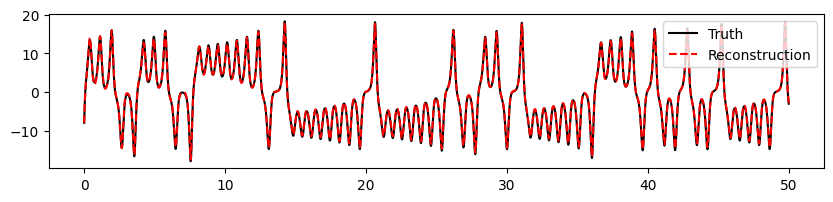

In [7]:
plt.figure(figsize=(10, 2))
plt.plot(t, x, c="k", label="Truth")
plt.plot(t, havok.reconstructed_data, "--", c="r", label="Reconstruction")
plt.legend()
plt.show()

### Data prediction

And generally speaking, fitted `HAVOK` models can make predictions as long as they are provided with an input forcing signal that goes beyond the training set. Call the `predict` method to execute this process. (Also note that the model must also be provided with the times at which this forcing was evaluated, and an initial condition for the linear portion of the dynamics. See method documentation for more details.)

Here, we demonstrate how the `HAVOK` model fitted previously is able to obtain a pretty decent prediction of the data for later times as long as it is given a forcing signal for those later times.

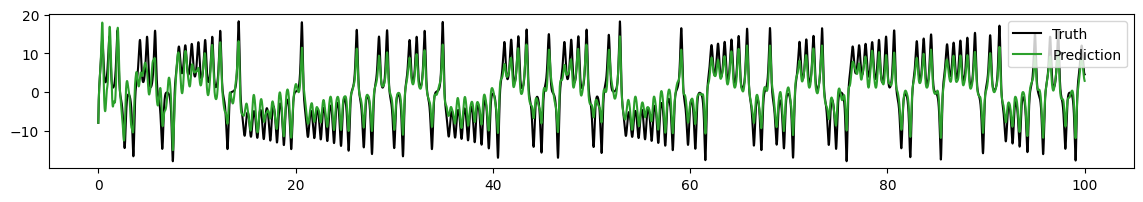

In [8]:
# Build a longer data set and fit a HAVOK model to it.
t_long = np.arange(2 * m) * dt
x_long = generate_lorenz_data(t_long)[0]
havok_long = HAVOK(svd_rank=16, delays=100).fit(x_long, t_long)

# We only use the long HAVOK model to obtain a long forcing signal.
forcing_long = havok_long.forcing
time_long = t_long[: len(forcing_long)]

# Make a prediction using the long forcing signal.
# Use the HAVOK model fitted to the shorter data set.
plt.figure(figsize=(14, 2))
plt.plot(t_long, x_long, c="k", label="Truth")
plt.plot(
    t_long,
    havok.predict(forcing_long, time_long),
    label="Prediction",
    c="tab:green",
)
plt.legend()
plt.show()

### Viewing U and $\Sigma$ matrices

`HAVOK` models also store SVD information that is obtained after taking the SVD of the Hankel matrix $\mathbf{H}$.

$$
\mathbf{H} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^*
$$

Invoke the `modes` attribute to view the entries of $\mathbf{U}$ and the `singular_vals` attribute to view the entries of $\mathbf{\Sigma}$. Note that the entries of $\mathbf{V}$ are what we are referring to when we talk about the "embeddings". Also note that below, we highlight the 16 leading singular values in order to clarify our consistent usage of `svd_rank=16`.

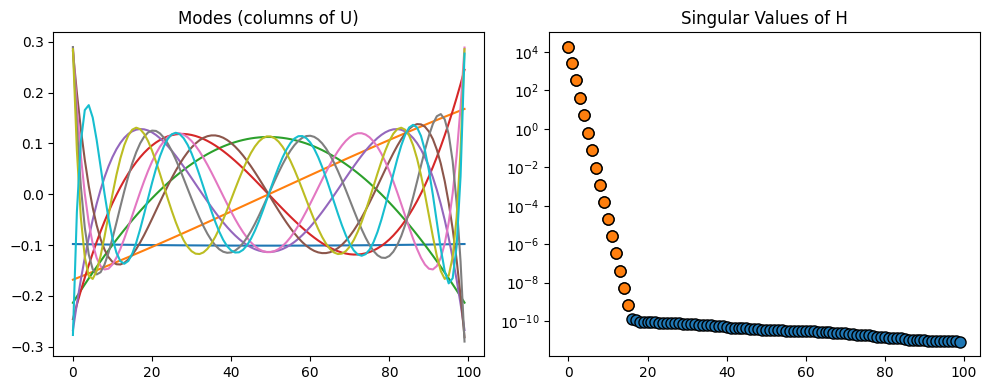

In [9]:
# Visualize the columns of U.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Modes (columns of U)")
havok = HAVOK(svd_rank=10, delays=100).fit(x, t)
plt.plot(havok.modes)

# Visualize the entries of Sigma. (Highlight the first 16.)
plt.subplot(1, 2, 2)
plt.title("Singular Values of H")
havok = HAVOK(svd_rank=-1, delays=100).fit(x, t)
plt.plot(havok.singular_vals, "o", mec="k", ms=8)
plt.plot(havok.singular_vals[:16], "o", mec="k", ms=8)
plt.semilogy()
plt.tight_layout()
plt.show()

### Threshold computation

Another nifty feature of the `HAVOK` module is that it comes equipped with a threshold computation tool. Simply invoke the `compute_threshold` function of your fitted `HAVOK` instance and it will return a recommended threshold value based on the computed forcing term and the arguments of the function.

Here, we demonstrate how one might adjust the parameter `p` of the function in order to adjust the forcing threshold. This parameter can roughly be thought of as the probability that a forcing event will occur. One may also plot the computed threshold against a histogram of the forcing values used and a Gaussian distribution fitted to the histogram if `plot=True`. As always, see method documentation for more details.

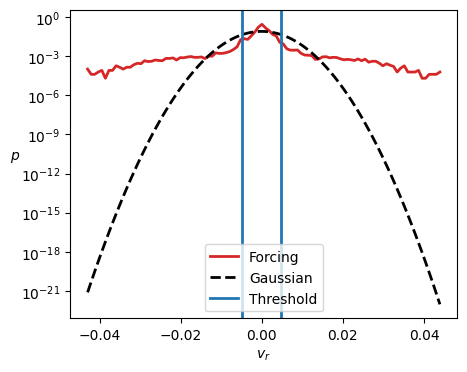

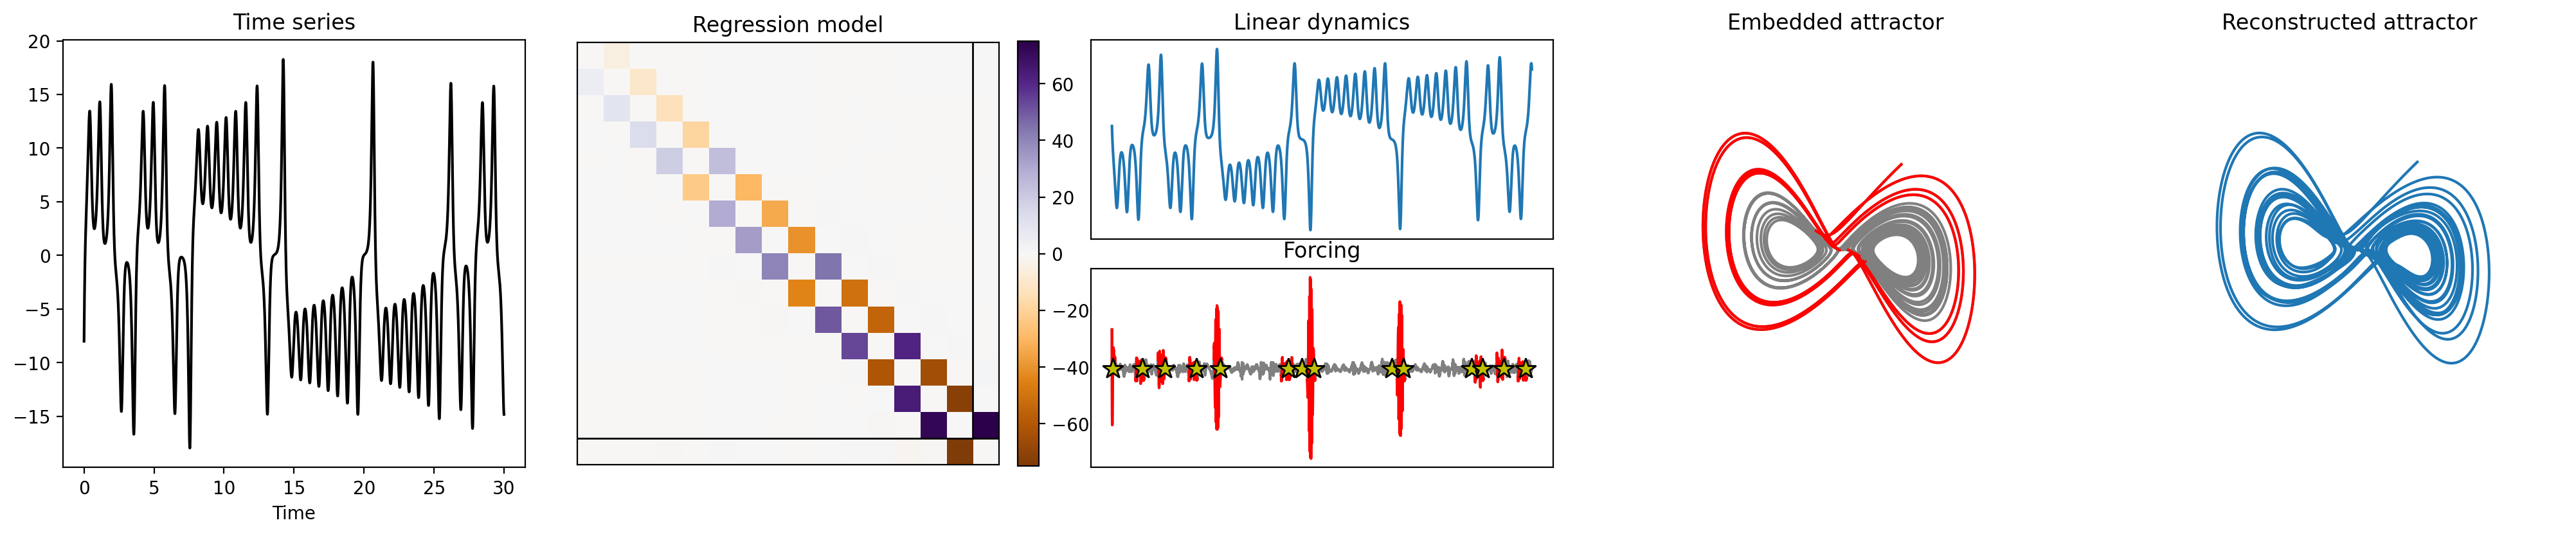

In [10]:
"""
def compute_threshold(
    self,
    forcing=0,
    p=0.01,
    bins=50,
    plot=False,
    plot_kwargs=None,
):
"""
# Re-fit the HAVOK model (because model was overwritten in the last block).
havok = HAVOK(svd_rank=16, delays=100).fit(x, t)

# Invoke the threshold computer.
thres = havok.compute_threshold(p=0.09, bins=100, plot=True)

# Invoke plot_summary using the computed threshold value.
havok.plot_summary(
    num_plot=30000,
    forcing_threshold=thres,
    true_switch_indices=get_ind_switch_lorenz(x),
)

### Choosing basic parameters

In the previous examples, we adjust the `svd_rank` and the `delays` parameters of our HAVOK models, which are arguably the two most significant parameters of the HAVOK algorithm. Basically,

- `svd_rank` controls the rank of the fit, i.e. the number of time-delay embeddings we want to keep, and
- `delays` controls the number of time-shifted rows to use in our Hankel matrix $\mathbf{H}$.

There are also a few things to note when assessing the quality of your HAVOK models:

- In the most ideal scenario, your HAVOK operator should be **skew-symmetric and tridiagonal**. This is probably one of the simplest visual cues to use when assessing the quality of your HAVOK models.
- Another good visual cue is the quality of your embedded attractor and your reconstructions. Ideally, your **embeddings should be smooth and your reconstructions should be accurate.**

With that being said, we now leave users with the following tips and comments:

- It is useful to monitor the quantity $q \Delta t$, where $q \equiv $ `delays`. When $q \Delta t$ becomes too large, the HAVOK operator tends to deviate from its ideal structure, and the embedded attractor becomes nonsensical. There is no exact $q \Delta t$ threshold that works for every data set. However, if you find that your HAVOK operators don't turn out to be skew-symmetric and tridiagonal, try *decreasing* `delays` (that or decrease $\Delta t$, however this usually isn't an option).

- An `svd_rank` that is too high will often cause HAVOK models to produce poor reconstructions. This is because the embeddings of excessively high-order HAVOK models begin to account for noise and generally useless information. In general, pick a rank after examining the singular value spectrum of your Hankel matrix, that or examine the HAVOK operator and truncate the rank accordingly to maintain a skew-symmetric tridiagonal structure.

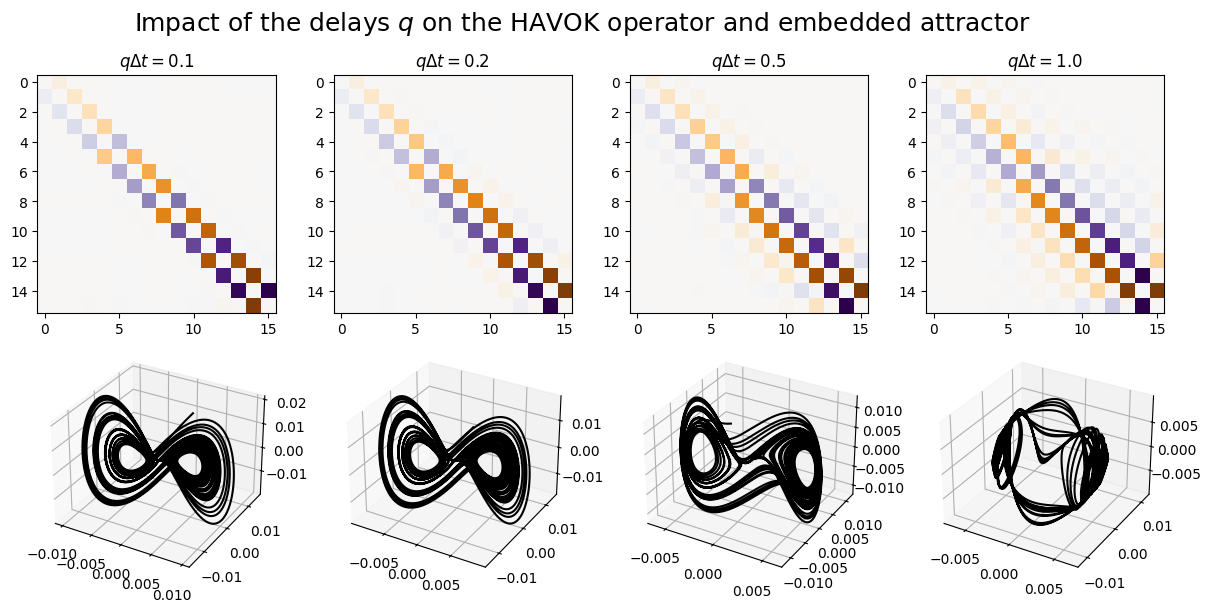

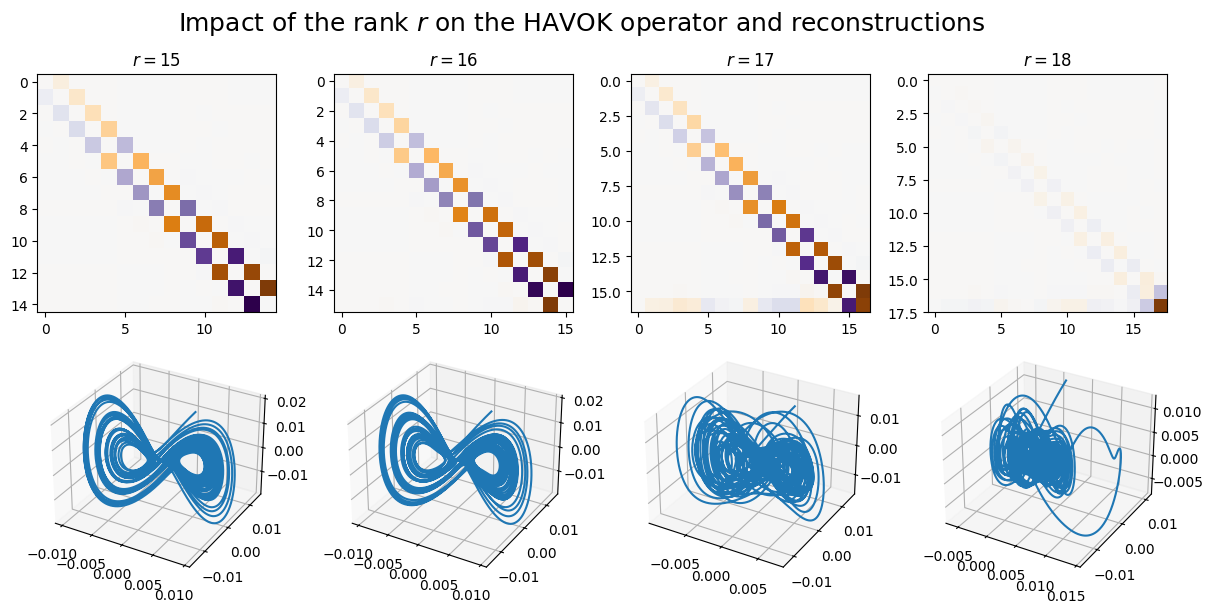

In [11]:
delay_values = [100, 200, 500, 1000]
rank_values = [15, 16, 17, 18]

fig = plt.figure(figsize=(12, 6))
plt.suptitle(
    "Impact of the delays $q$ on the HAVOK operator and embedded attractor",
    fontsize=18,
)
for i, delays in enumerate(delay_values):
    # Fit the HAVOK model:
    havok = HAVOK(svd_rank=16, delays=delays)
    havok.fit(x, t)
    # Plot the HAVOK operator:
    ax = fig.add_subplot(2, 4, i + 1)
    vmax = np.abs(havok.operator).max()
    ax.set_title(f"$q \Delta t = {delays * dt}$")
    ax.imshow(havok.operator.real, vmax=vmax, vmin=-vmax, cmap="PuOr")
    # Plot the HAVOK reconstruction:
    ax = fig.add_subplot(2, 4, i + 5, projection="3d")
    ax.plot(
        havok.linear_dynamics[:, 0],
        havok.linear_dynamics[:, 1],
        havok.linear_dynamics[:, 2],
        c="k",
    )
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.suptitle(
    "Impact of the rank $r$ on the HAVOK operator and reconstructions",
    fontsize=18,
)
for i, svd_rank in enumerate(rank_values):
    # Fit the HAVOK model:
    havok = HAVOK(svd_rank=svd_rank, delays=100)
    havok.fit(x, t)
    # Plot the HAVOK operator:
    ax = fig.add_subplot(2, 4, i + 1)
    vmax = np.abs(havok.operator).max()
    ax.set_title(f"$r = {svd_rank}$")
    ax.imshow(havok.operator.real, vmax=vmax, vmin=-vmax, cmap="PuOr")
    # Plot the HAVOK reconstruction:
    ax = fig.add_subplot(2, 4, i + 5, projection="3d")
    ax.plot(
        havok.reconstructed_embeddings[:, 0],
        havok.reconstructed_embeddings[:, 1],
        havok.reconstructed_embeddings[:, 2],
    )
plt.tight_layout()
plt.show()

## References:

[1] S. L. Brunton, B. W. Brunton, J. L. Proctor, E. Kaiser, and J. N. Kutz, *Chaos
as an intermittently forced linear system*, Nature Communications, 8 (2017), pp. 1–9. [https://doi.org/10.1038/s41467-017-00030-8](https://doi.org/10.1038/s41467-017-00030-8)